# Time series analysis of < S&P 500 historical data >

- S&P 500 is a stock market index measuring the stocks performance of 500 large companies listed on stock exchanges in the US
- S&P index is associated with many ticker symbols, including: ^GSPC, INX, and SPX.
- Here I used ^GSPC index downloaded from yahoo using pandas_datareader <br>
  Also, indivisual data of 500 company downloaded from:
    https://www.kaggle.com/camnugent/sandp500

<Font color= navy>__Import data: GSPC index__

In [1]:
import pandas_datareader as pdr

start_date = '1995-01-01'
end_date = '2020-06-01'

GSPC = pdr.DataReader('^GSPC', 'yahoo', start_date,end_date)

In [2]:
GSPC.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1995-01-03,459.269989,457.200012,459.209991,459.109985,262450000,459.109985
1995-01-04,460.720001,457.559998,459.130005,460.709991,319510000,460.709991
1995-01-05,461.299988,459.750000,460.730011,460.339996,309050000,460.339996
1995-01-06,462.489990,459.470001,460.380005,460.679993,308070000,460.679993
1995-01-09,461.769989,459.739990,460.670013,460.829987,278790000,460.829987


<Font color= navy>__Plot adjacent close__

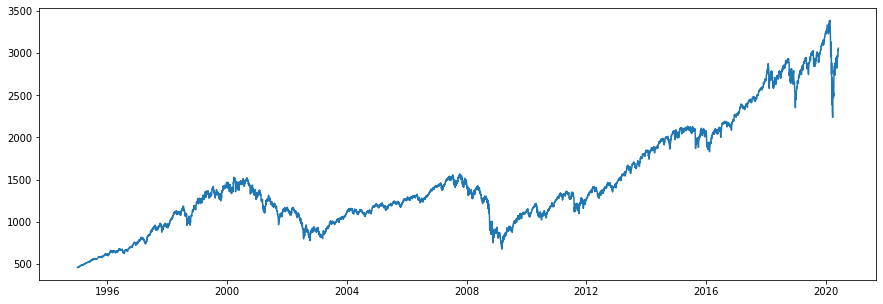

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(GSPC["Adj Close"])
plt.show()

<Font color= navy>__Decompose time series into trend and seasonality__
: Additive decomposition

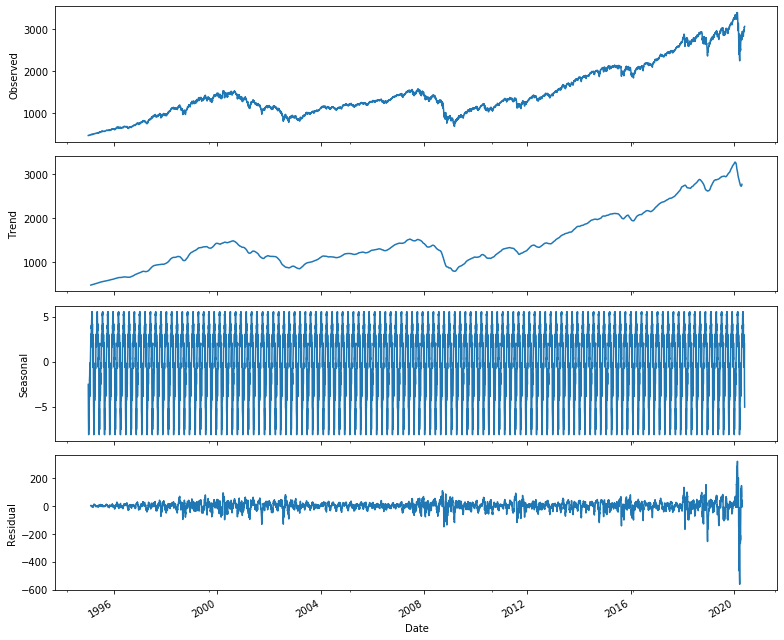

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(GSPC["Adj Close"], model='additive', freq=52)
result.plot()
plt.show()

<Font color= navy>__Decompose time series into trend and seasonality__
: Multiplicative decomposition

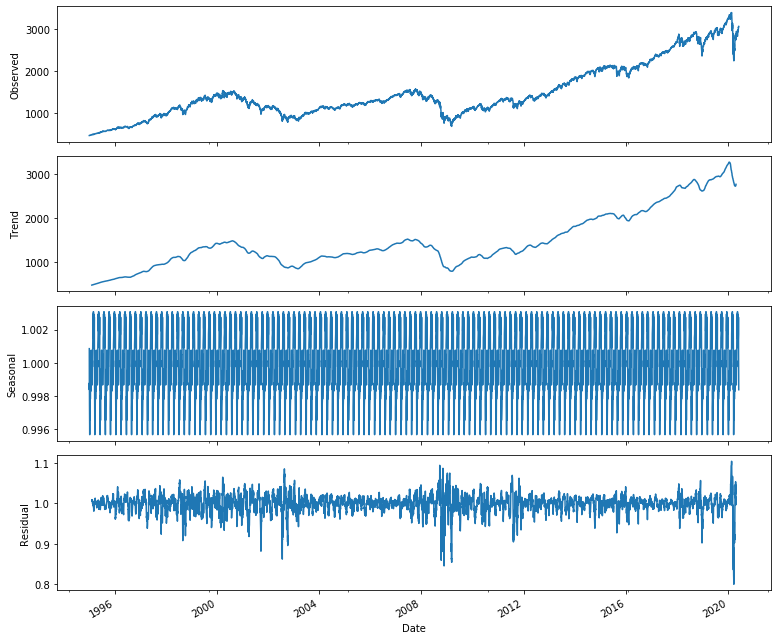

In [8]:
rcParams['figure.figsize'] = 11, 9

result = seasonal_decompose(GSPC["Adj Close"], model='multiplicative', freq=52)
result.plot()
plt.show()

<Font color= navy>__ACF(autocorrelation funcion) and PACF (partial autocorrelation function) Analysis__
 to determine the order of ARIMA model

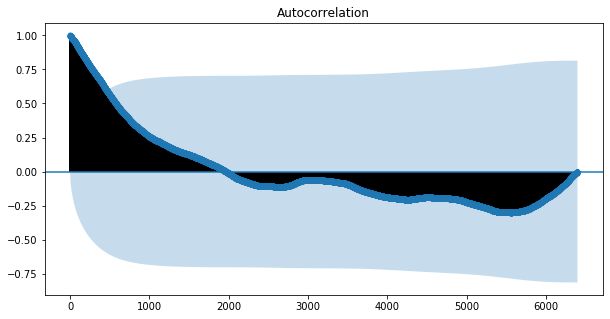

In [20]:
# ACF
rcParams['figure.figsize'] = 10, 5

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(GSPC["Adj Close"])
plt.show()

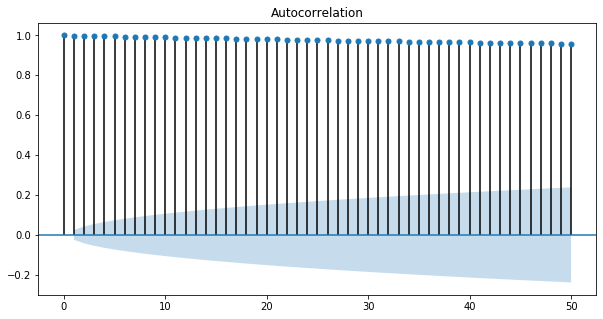

In [21]:
plot_acf(GSPC["Adj Close"], lags=50)
plt.show()

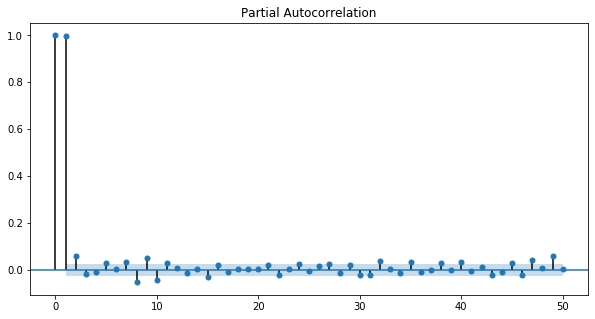

In [18]:
# PACF
rcParams['figure.figsize'] = 10, 5

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(GSPC["Adj Close"], lags=50)
plt.show()

<Font color= navy>__Test if time series is stationary__

In [4]:
series = (GSPC["Adj Close"])
split = round(len(series) / 2)
series1, series2 = series[0:split], series[split:]
mean1, mean2 = series1.mean(), series2.mean()
var1, var2 =series1.var(), series2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1082.614371, mean2=1845.993009
variance1=74594.757243, variance2=428739.638584


In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

/Users/yujikim/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ADF Statistic: 0.140812
p-value: 0.968740
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


--> Since p_value > 0.05, it failed to reject the null hypothesis (H0), that data is non-stationary. It means data is non-stationary and time-dependant.

<Font color= navy>__Differencing data to make non-stationary data to stationary__

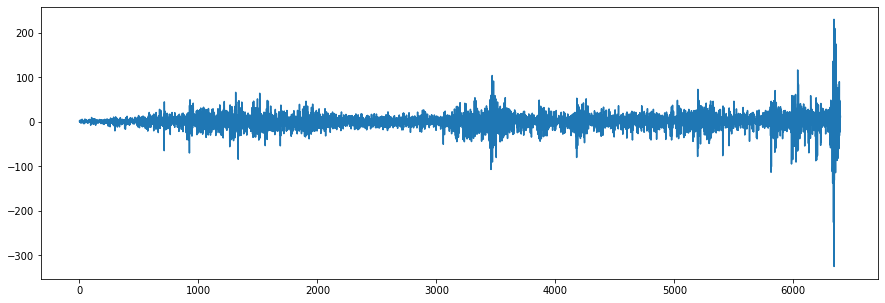

In [12]:
import numpy as np
diff_series = np.diff(series)

plt.figure(figsize=(15,5))
plt.plot(diff_series)
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.722230
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


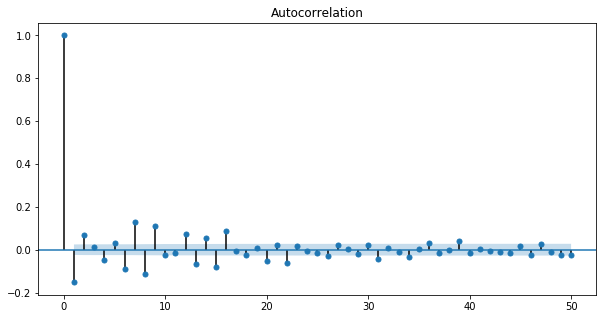

In [23]:
plot_acf(diff_series, lags=50)
plt.show()

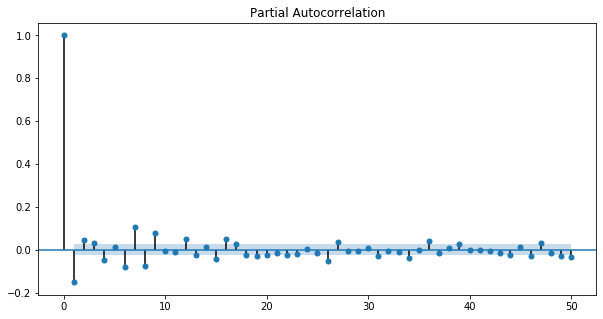

In [24]:
plot_pacf(diff_series, lags=50)
plt.show()

In [18]:
len(series)

6398

In [6]:
train = series[:5000]
test = series[5000:]

In [36]:
from statsmodels.tsa.arima_model import ARIMA
def objfunc(z):
    p,d,q = z
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit(disp=0)
    return model_fit.aic

from scipy.optimize import brute
grid = (slice(0, 2, 1), slice(0, 2, 1), slice(0, 2, 1))
resbrute=brute(objfunc, grid,  finish=None)

In [32]:
resbrute

array([1., 1., 1.])

In [37]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 4999
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20173.405
Method:                       css-mle   S.D. of innovations             13.688
Date:                Wed, 17 Jun 2020   AIC                          40354.809
Time:                        09:17:57   BIC                          40380.877
Sample:                             1   HQIC                         40363.946
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3142      0.162      1.934      0.053      -0.004       0.633
ar.L1.D.Adj Close     0.5913      0.116      5.076      0.000       0.363       0.820
ma.L1.D.Adj Close    -0.

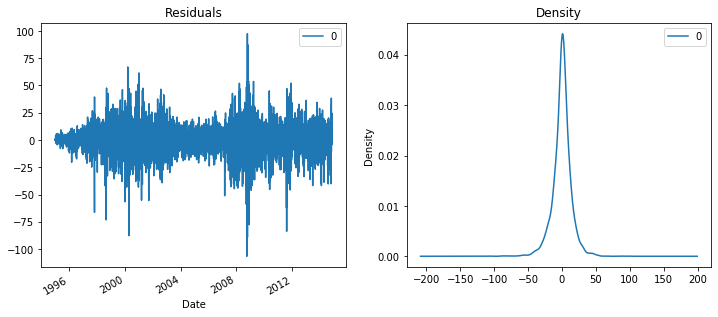

In [38]:
import pandas as pd
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

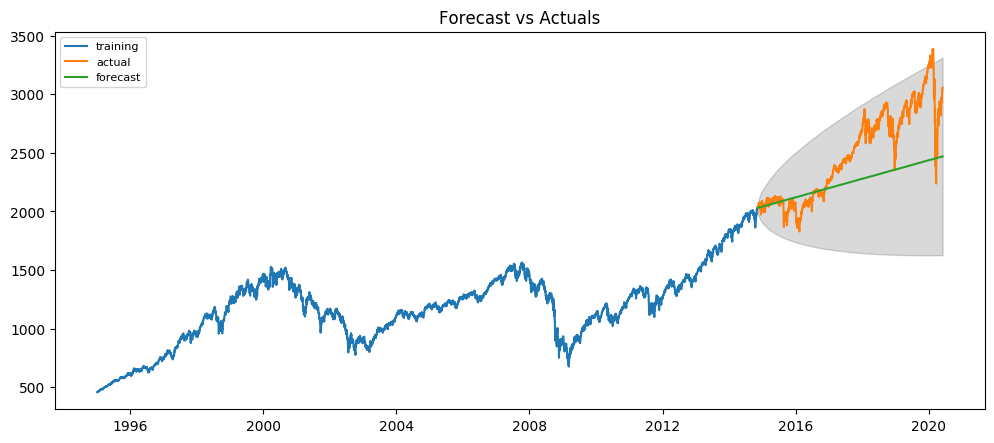

In [39]:
# Forecast
fc, se, conf = model_fit.forecast(1398, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()